In [96]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# !pip install gdown
# !pip install geopandas
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import matplotlib.pyplot as plt
import geopandas
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [97]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code:  4/1AfJohXnRy41yun9U3tqMK31XSEbtlICNEGmQbrgSkKSyv2mUzSIjysXPpFg



Successfully saved authorization token.


# Obtain the region of interest

In [98]:
roi = ee.Geometry.Polygon(
          [[[101.00841298710328, 3.5840956245106925],
            [101.15672841679078, 3.3538056172134443],
            [101.30779042850953, 3.4442833673276585],
            [101.11003652225953, 3.655364290850406],
            [101.15672841679078, 3.710182494184478],
            [101.02763906132203, 3.8061061368075664],
            [100.87932363163453, 3.6992191239822603]]]);

# roi_area = roi.area(10)

startDate = ee.Date('2021-09-01');
endDate =  ee.Date('2023-09-01');

# Obtain Sentinel-2 imagery

In [99]:
# Create image collection of S-2 imagery for the perdiod 2019-2020
S2 = (ee.ImageCollection('COPERNICUS/S2')
       #filter start and end date
       .filter(ee.Filter.date(startDate, endDate))
       .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than',100)
       #filter according to drawn boundary
       .filterBounds(roi))

num_pixels = 1000

In [100]:
# Define the function to add NDVI band.
def addNDVI(image):
    ndvi = image.normalizedDifference(['B8', 'B4'])
    return image.addBands(ndvi).select(['nd'])

# Create an image collection of Sentinel-2 imagery for the period 2019-2020.
S2 = ee.ImageCollection('COPERNICUS/S2') \
      .filter(ee.Filter.date(startDate, endDate)) \
      .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 100) \
      .filterBounds(roi)

# Map the addNDVI function to the S2 Image Collection.
S2 = S2.map(addNDVI)

# Select the NDVI band.
NDVI = S2.select('nd')

# Generate a sequence of numbers from 0 to months.
sequence = list(range(24))

# Create a list to store monthly image subsets.
sequence_s1 = []

# Convert start and end dates to ee.Date objects.
start_date = ee.Date(startDate)
end_date = ee.Date(endDate)

# Define the function to create monthly intervals.
def createMonthlyInterval(num):
    num = ee.Number(num)
    start_interval = start_date.advance(num, 'month')
    end_interval = start_date.advance(num.add(1), 'month')
    subset = NDVI.filterDate(start_interval, end_interval)
    return subset.max().set('system:time_start', start_interval)

# Iterate over all months within the date range.
num_months = end_date.difference(start_date, 'month').toInt().getInfo()
for month in range(num_months + 1):
    subset = createMonthlyInterval(month)
    sequence_s1.append(subset)

# Create an ImageCollection from the list of monthly subsets.
byMonthYear = ee.ImageCollection.fromImages(sequence_s1)

# Rename the bands.
bandsName = ['2020-09', '2020-10', '2020-11', '2020-12',
             '2021-01', '2021-02', '2021-03', '2021-04',
             '2021-05', '2021-06', '2021-07', '2021-08',
             '2021-09', '2021-10', '2021-11', '2021-12',
             '2022-01', '2022-02', '2022-03', '2022-04',
             '2022-05', '2022-06', '2022-07', '2022-08']

multiband1_ndvi = byMonthYear.toBands().clip(roi).rename(bandsName)

# Get Sentinel-1 data
sentinel1_vh = ee.ImageCollection('COPERNICUS/S1_GRD') \
              .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
              .select('VH') \
              .filter(ee.Filter.eq('instrumentMode', 'IW')) \
              .filter(ee.Filter.eq('resolution_meters', 10)) \
              .filter(ee.Filter.date(startDate, endDate)) \
              .filter(ee.Filter.bounds(roi))

# Create a list to store a sequence of s1
sequence_s1 = []

# Define the function to create monthly intervals for Sentinel-1
def createMonthlyIntervalS1(num):
    num = ee.Number(num)
    start_interval = start_date.advance(num, 'month')
    end_interval = start_date.advance(num.add(1), 'month')
    subset = sentinel1_vh.filterDate(start_interval, end_interval)
    return subset.median().set('system:time_start', start_interval)

# Iterate over all months within the date range.
for month in range(num_months + 1):
    subset = createMonthlyIntervalS1(month)
    sequence_s1.append(subset)

# Create an ImageCollection from the list of monthly subsets.
byMonthYearS1 = ee.ImageCollection.fromImages(sequence_s1)

multibands1 = byMonthYearS1.toBands().clip(roi).rename(bandsName)

# Combine the bands from Sentinel-1 and Sentinel-2
combinedband = multiband1_ndvi.addBands(multibands1)

# Create a training dataset for clustering
training = combinedband.sample(
    region=roi,
    scale=10,
    numPixels=num_pixels,
    tileScale=8
)

# Define the number of clusters
num_clusters = 7

# Create a K-Means clusterer and train it on the training data
clusterer = ee.Clusterer.wekaKMeans(num_clusters).train(
    features=training
)

# Cluster the combined bands
result_cluster = combinedband.cluster(clusterer).byte()
remapped_cluster = result_cluster.rename('remapped')

In [101]:
# Generate random points within the specified region
random_points = ee.FeatureCollection.randomPoints(region=roi, points=num_pixels, seed=123)

# Sample the 'result_cluster' image to get cluster labels for the points, limiting the number of samples.
cluster_labels = result_cluster.sample(
    region=random_points,  # Use the feature collection of points as the region.
    scale=10,  # Adjust the scale as needed.
    numPixels=num_pixels  # Limit the number of sampled elements.
)

# Add the cluster bands to the multiband1_ndvi image
comb_ndvi_cluster = multiband1_ndvi.addBands(remapped_cluster)

# Print the combined image (optional)
# print("comb_ndvi_cluster", comb_ndvi_cluster)

# Sample the 'comb_ndvi_cluster' image to get NDVI and cluster labels for the points, limiting the number of samples.
ndvi_series = comb_ndvi_cluster.sample(
    region=random_points,  # Use the feature collection of points as the region.
    scale=10,  # Adjust the scale as needed.
    numPixels=num_pixels  # Limit the number of sampled elements.
)

In [102]:
# Define the export parameters
export_params = {
    'collection': random_points,
    'folder': 'megathonAPIattempt',  # Replace with your Google Drive folder
    'description': 'random_points_export',
    'fileFormat': 'GeoJSON',  # Choose the desired format
}

# Start the export task
export_task = ee.batch.Export.table.toDrive(**export_params)
export_task.start()

In [103]:
# Define the export parameters
export_params = {
    'collection': ndvi_series,
    'folder': 'megathonAPIattempt',  # Replace with your Google Drive folder
    'description': 'ndvi_clusters_export',
    'fileFormat': 'GeoJSON',  # Choose the desired format
}

# Start the export task
export_task = ee.batch.Export.table.toDrive(**export_params)
export_task.start()

In [113]:
import pandas as pd
import geojson
import gdown

# Define the file IDs and output file names
file_ids = ['1Bb7EGtRJHZuwXzUjm-yknIBJbwli0eh3', '1EolHhiQ3Gdpcy3E6N6xYSjKo_BymqckY']
output_files = ['ndvi_series.geojson', 'random_points.geojson']

# Download the GeoJSON files
for file_id, output_file in zip(file_ids, output_files):
    gdown.download(f'https://drive.google.com/uc?id={file_id}', output_file, quiet=False)

# Convert GeoJSON files to Pandas DataFrames
data_frames = []
for output_file in output_files:
    with open(output_file) as f:
        gf = geojson.load(f)
    features = gf['features']

    # Convert the features to a Pandas DataFrame
    data = []
    for feature in features:
        properties = feature['properties']
        geometry = feature['geometry']
        data.append({**properties, 'geometry': geometry})

    # Create a Pandas DataFrame and add it to the list
    df = pd.DataFrame(data)
    data_frames.append(df)

# Access the DataFrames
ndvi_series_df = data_frames[0]
random_points_df = data_frames[1]

# Display the first few rows of the DataFrames
print("NDVI Series DataFrame:")
print(ndvi_series_df.head())

print("\nRandom Points DataFrame:")
print(random_points_df.head())


Downloading...
From: https://drive.google.com/uc?id=1Bb7EGtRJHZuwXzUjm-yknIBJbwli0eh3
To: /kaggle/working/ndvi_series.geojson
100%|██████████| 611k/611k [00:00<00:00, 97.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EolHhiQ3Gdpcy3E6N6xYSjKo_BymqckY
To: /kaggle/working/random_points.geojson
100%|██████████| 127k/127k [00:00<00:00, 83.6MB/s]

NDVI Series DataFrame:
    2020-09   2020-10   2020-11   2020-12   2021-01   2021-02   2021-03  \
0  0.699049  0.779767  0.800274  0.771225  0.687484  0.504027  0.524445   
1  0.717746  0.694226  0.720000  0.715550  0.566676  0.464343  0.478468   
2  0.665711  0.721819  0.695303  0.737259  0.628548  0.451869  0.452813   
3  0.636029  0.657786  0.668536  0.658349  0.410300  0.183149  0.424072   
4  0.700270  0.662227  0.761313  0.741066  0.579899  0.465673  0.484913   

    2021-04   2021-05   2021-06  ...   2022-01   2022-02   2022-03   2022-04  \
0  0.529722  0.300135  0.436391  ...  0.318306  0.374525  0.487465  0.419759   
1  0.512791  0.446196  0.425696  ...  0.323514  0.418357  0.438880  0.441120   
2  0.432221  0.460554  0.390270  ...  0.359716  0.355715  0.450164  0.262936   
3  0.394225  0.198130  0.268101  ...  0.310173  0.248667  0.177965  0.221531   
4  0.520630  0.275740  0.464900  ...  0.309478  0.395280  0.463391  0.392676   

    2022-05   2022-06   2022-07   2022-08  re

In [114]:
df1 = ndvi_series_df
df1.head()

,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,...,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,remapped,geometry
0,0.699049,0.779767,0.800274,0.771225,0.687484,0.504027,0.524445,0.529722,0.300135,0.436391,...,0.318306,0.374525,0.487465,0.419759,0.498903,0.502210,0.392870,0.436133,4,"{'type': 'MultiPoint', 'coordinates': []}"
1,0.717746,0.694226,0.720000,0.715550,0.566676,0.464343,0.478468,0.512791,0.446196,0.425696,...,0.323514,0.418357,0.438880,0.441120,0.434377,0.475484,0.422834,0.462825,4,"{'type': 'MultiPoint', 'coordinates': []}"
2,0.665711,0.721819,0.695303,0.737259,0.628548,0.451869,0.452813,0.432221,0.460554,0.390270,...,0.359716,0.355715,0.450164,0.262936,0.418040,0.439417,0.337326,0.435147,4,"{'type': 'MultiPoint', 'coordinates': []}"
3,0.636029,0.657786,0.668536,0.658349,0.410300,0.183149,0.424072,0.394225,0.198130,0.268101,...,0.310173,0.248667,0.177965,0.221531,0.390104,0.434588,0.303900,0.265674,5,"{'type': 'MultiPoint', 'coordinates': []}"
4,0.700270,0.662227,0.761313,0.741066,0.579899,0.465673,0.484913,0.520630,0.275740,0.464900,...,0.309478,0.395280,0.463391,0.392676,0.490766,0.499749,0.433565,0.370288,4,"{'type': 'MultiPoint', 'coordinates': []}"


In [115]:
df2 = random_points_df
df2.head()

,geometry
0,"{'type': 'Point', 'coordinates': [101.178733, ..."
1,"{'type': 'Point', 'coordinates': [101.092909, ..."
2,"{'type': 'Point', 'coordinates': [101.122522, ..."
3,"{'type': 'Point', 'coordinates': [101.168789, ..."
4,"{'type': 'Point', 'coordinates': [101.136343, ..."


In [116]:
# Merge df1, df2 using id
# Append df2 to df1 to create df3
df3 = df1
df3['geometry'] = df2['geometry']
df3.head()

,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,...,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,remapped,geometry
0,0.699049,0.779767,0.800274,0.771225,0.687484,0.504027,0.524445,0.529722,0.300135,0.436391,...,0.318306,0.374525,0.487465,0.419759,0.498903,0.502210,0.392870,0.436133,4,"{'type': 'Point', 'coordinates': [101.178733, ..."
1,0.717746,0.694226,0.720000,0.715550,0.566676,0.464343,0.478468,0.512791,0.446196,0.425696,...,0.323514,0.418357,0.438880,0.441120,0.434377,0.475484,0.422834,0.462825,4,"{'type': 'Point', 'coordinates': [101.092909, ..."
2,0.665711,0.721819,0.695303,0.737259,0.628548,0.451869,0.452813,0.432221,0.460554,0.390270,...,0.359716,0.355715,0.450164,0.262936,0.418040,0.439417,0.337326,0.435147,4,"{'type': 'Point', 'coordinates': [101.122522, ..."
3,0.636029,0.657786,0.668536,0.658349,0.410300,0.183149,0.424072,0.394225,0.198130,0.268101,...,0.310173,0.248667,0.177965,0.221531,0.390104,0.434588,0.303900,0.265674,5,"{'type': 'Point', 'coordinates': [101.168789, ..."
4,0.700270,0.662227,0.761313,0.741066,0.579899,0.465673,0.484913,0.520630,0.275740,0.464900,...,0.309478,0.395280,0.463391,0.392676,0.490766,0.499749,0.433565,0.370288,4,"{'type': 'Point', 'coordinates': [101.136343, ..."


In [117]:
print(df3['geometry'][0])

{"coordinates": [101.178733, 3.573203], "type": "Point"}


In [118]:
# Rename geometry_y to geometry
df3 = df3.rename(columns={'geometry_y': 'geometry'})
df3 = df3.rename(columns={'remapped': 'clustered_label'})

# Put x coordinates of the POINTS type into the x column
df3['x'] = df3['geometry'].apply(lambda p: p.coordinates[0])
df3['y'] = df3['geometry'].apply(lambda p: p.coordinates[1])

In [119]:
df3 = df3.drop(['geometry'], axis=1)
df4 = df3.groupby(['clustered_label']).mean()
df5 = df4.drop(['x', 'y'], axis=1)

time_series = df5.values.tolist()

In [120]:
df5.head(10)

,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,...,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08
clustered_label,,,,,,,,,,,,,,,,,,,,,
0,0.405805,0.672866,0.622610,0.452363,0.218105,0.092924,0.316502,0.446102,0.377938,0.197734,...,0.345783,0.106744,0.103855,0.118156,0.318711,0.396266,0.345143,0.180327,0.120154,0.125913
1,0.667389,0.654930,0.658431,0.671337,0.639124,0.393714,0.438309,0.417967,0.404860,0.408565,...,0.355725,0.272067,0.299115,0.356120,0.416718,0.406036,0.407553,0.433687,0.366916,0.308377
2,0.262264,0.314052,0.274867,0.270182,0.241200,0.144518,0.177532,0.194250,0.174897,0.160682,...,0.180149,0.129839,0.133121,0.161313,0.175041,0.171346,0.168536,0.150690,0.164210,0.138875
3,0.044226,0.032104,0.035579,-0.001165,0.025007,0.022602,-0.001559,0.026559,0.024759,0.027512,...,0.032006,0.022347,0.025811,0.030944,-0.015905,0.027588,0.029848,-0.018903,0.018856,0.023820
4,0.715955,0.710936,0.734091,0.722190,0.631262,0.449852,0.475232,0.459213,0.454773,0.429355,...,0.415196,0.360422,0.344931,0.373130,0.465238,0.453046,0.457552,0.473481,0.425458,0.252227
5,0.594878,0.429229,0.414912,0.382291,0.330170,0.295743,0.369803,0.296581,0.251670,0.226694,...,0.227212,0.178791,0.179260,0.290521,0.360280,0.280854,0.255740,0.238427,0.220933,0.275104
6,0.255748,0.188926,0.619440,0.701169,0.474142,0.175954,0.137614,0.154198,0.363824,0.382180,...,0.309125,0.386629,0.209075,0.142691,0.140969,0.132273,0.295601,0.428375,0.348708,0.112848


0.5896697045137094
0.5659008884392952
0.3509130318695678
0.09082876421147916
0.7166344134976311
0.37730638401596606
0.5697151246454146


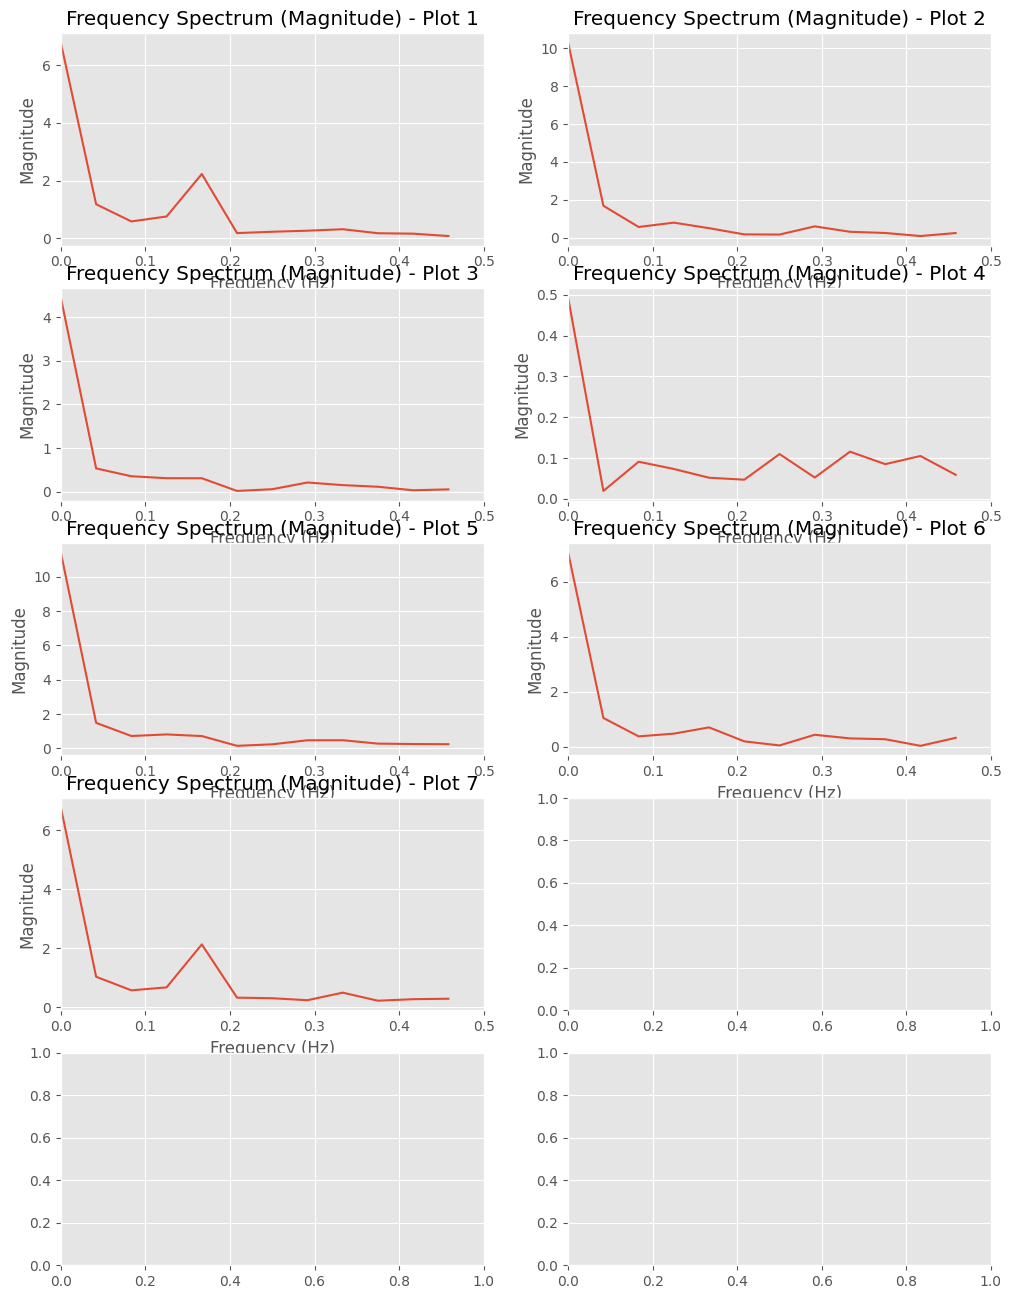

[1, 0, 0, 0, 0, 0, 1]


In [121]:
import numpy as np
import matplotlib.pyplot as plt

tru = []
fs = 1.0  # Set your desired sampling frequency (e.g., 1 Hz)
dt = 1.0 / fs
sz = len(time_series)
freql = []

plt.style.use('ggplot')

fig, axs = plt.subplots(5, 2, figsize=(12, 16))  # Create a 5x2 grid of subplots

for i in range(sz):
    N = len(time_series[i])
    fft_result = np.fft.fft(time_series[i])
    fft_result = np.fft.fftshift(fft_result)  # Shift the FFT result
    freq = np.fft.fftfreq(N, dt)
    freq = np.fft.fftshift(freq)  # Shift the frequency values

    row = i // 2  # Calculate the row for the subplot
    col = i % 2   # Calculate the column for the subplot

    # Plot the magnitude of the FFT result in the appropriate subplot
    axs[row, col].plot(freq, np.abs(fft_result))
    axs[row, col].set_title(f"Frequency Spectrum (Magnitude) - Plot {i+1}")
    axs[row, col].set_xlabel("Frequency (Hz)")
    axs[row, col].set_ylabel("Magnitude")
    axs[row, col].set_xlim(0, fs / 2)  # Plot both positive and negative frequencies

    prev = 0
    ok = 0
    max_val = 0

    for j in range(len(freq)):
        if (freq[j] < 0.1 and freq[j+1] > 0.1):
            prev = np.abs(fft_result[j])
            print(prev)
        if(freq[j] > 0.1 and freq[j] < 0.2):
            if(np.abs(fft_result[j]) > 2 * prev):
                ok = 1
                if (max_val < np.abs(fft_result[j])):
                    max_val = np.abs(fft_result[j])
        if(max_val < np.abs(fft_result[j]) and freq[j] != 0):
            ok = 0

    if (ok == 0):
        tru.append(0)
    else:
        tru.append(1)

plt.show()

print(tru)